# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 23

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 285
Num noneffect sequences: 	 285
Num scores: 	 	 	 285


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.4500909557238832
Median KS-test p-value: 	 0.4102712220692733
St. Dev KS-test p-value: 	 0.3096337995703546
Max KS-test p-value: 	 	 0.9999412276446716
Min KS-test p-value: 	 	 4.315415703616357e-12
Num significant p-values: 	 21

Mean non-zero motif length: 	 8.917355371900827
Median non-zero motif length: 	 8
St. Dev non-zero motif length: 	 6.219039015876307
Max non-zero motif length: 	 26
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.68421052631579
Median motif length: 	 	 10
St. Dev motif length: 	 	 2.788039689035162
Max motif length: 	 	 26
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 252


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 252


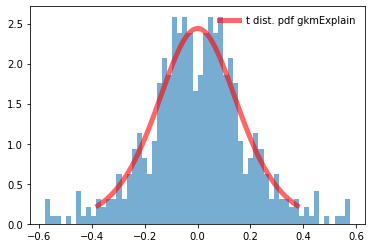

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 6.566628105746963
Mean: 	 -8.837114093344533e-08
Stdev: 	 0.15749707648486974

KstestResult(statistic=0.02400146739899897, pvalue=0.9335878103432941)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 108


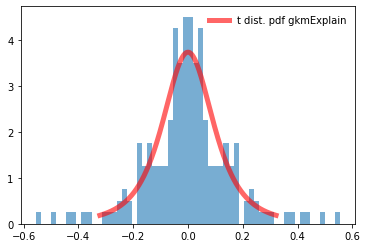

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 2.853537131448729
Mean: 	 -1.5284968463825295e-07
Stdev: 	 0.09812591772307308

KstestResult(statistic=0.036728895732680344, pvalue=0.932687273105946)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 108


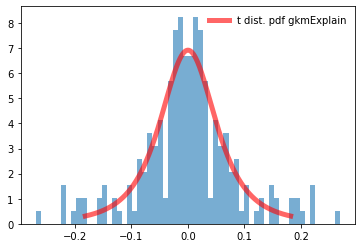

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 2.621901776961093
Mean: 	 1.0618633459957418e-07
Stdev: 	 0.05251403646205196

KstestResult(statistic=0.046352713485901864, pvalue=0.7421908177526261)


## Distribution of ISM Scores

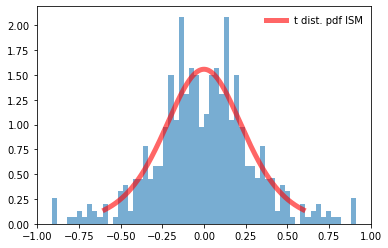

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 6.327027609862455
Mean: 	 -4.348050298972568e-07
Stdev: 	 0.24636949805053668

KstestResult(statistic=0.026647066403971187, pvalue=0.8666241209297014)


## Distribution of Delta Scores

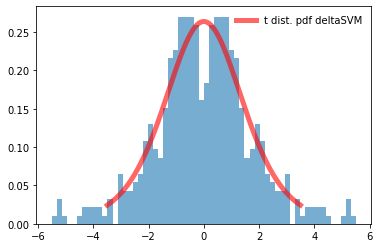

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 6.486464847259615
Mean: 	 -1.378521971466839e-06
Stdev: 	 1.455189389144092

KstestResult(statistic=0.025453561416706516, pvalue=0.8997035852106081)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.37746238118362585
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.3215469579430073
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.08946295380537793
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.18162001075998446
Negative ISM Cutoff: 	 	 	 	 	 -0.5953716984398629
Negative deltaSVM Cutoff: 	 	 	 	 -3.4969804781675116

Total SNPs with Negative Scores: 	 	 	 8
Confident SNPs with Negative Scores: 	 	 	 5
Highly Confident SNPs with Negative Scores: 	 	 3


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
270,chr6,27772520,27772521,rs760587,C,A,C,A,C,A,-,110,0.365373,0.920711,0.288997,0.504763,-0.569163,-0.555338,-0.215766,-0.892651,-5.098069,Nalls_23andMe,6.436710e-06,False,True,CAGCAAACAAAGGCT,0.009572,0.012487,0.033658,0.010085,0.011252,0.156811,2
206,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.175162,0.659880,0.106107,0.302095,-0.565061,-0.484718,-0.195987,-0.889765,-5.149891,Chang_23andMe_Parkinsons,2.349340e-03,False,True,GAGGGCGCTGTT,0.009896,0.017886,0.042062,0.010233,0.010751,0.426036,2
53,chr16,31117293,31117294,rs4889619,T,C,C,"G,T",C,"G,T",+,48,-0.019444,0.262166,0.132352,0.323881,-0.438488,-0.181053,-0.191529,-0.739295,-4.237210,Chang_23andMe_Parkinsons,3.401380e-02,False,True,CGGAGGCGG,0.028968,0.166915,0.044335,0.022485,0.024622,0.813377,2
262,chr4,89837895,89837896,rs2619363,T,G,G,"C,T",G,"C,T",+,103,0.508531,0.957855,0.361376,0.511700,-0.449757,-0.437651,-0.150324,-0.677981,-4.150311,23andme_PD_hg38,1.427720e-08,True,True,CCAATCAGCGCCTGCCAGACGCT,0.026234,0.023306,0.075568,0.031455,0.026718,0.255785,1
24,chr11,86103987,86103988,rs1237999,A,G,G,A,A,G,+,16,-0.040433,0.260167,0.002558,0.132986,-0.458425,-0.256057,-0.130428,-0.714403,-4.092868,Alzheimers_Jansen_2018,7.143148e-16,False,True,TGAGTCA,0.024319,0.083939,0.101186,0.025743,0.028207,0.496179,1
266,chr5,103120549,103120550,rs26523,T,C,C,T,C,T,-,104,-0.019314,0.037364,0.000000,0.033219,-0.444811,-0.037364,-0.033219,-0.695539,-4.004743,Nalls_23andMe,1.084830e-03,False,True,GAGGCGGCTG,0.027399,0.729934,0.577817,0.028549,0.030666,0.760935,0
128,chr17,75032747,75032748,rs7218004,A,G,G,A,G,A,+,61,0.000000,0.000000,0.000000,0.000000,-0.497128,0.000000,0.000000,-0.778122,-4.451715,Alzheimers_Kunkle_2019,8.541000e-06,True,True,GGGCGGGTTG,0.017418,0.999999,0.999999,0.018256,0.020165,0.332980,0
217,chr3,122416407,122416408,rs55911744,T,G,T,G,T,G,-,86,0.000000,0.000000,0.000000,0.000000,-0.421889,0.000000,0.000000,-0.661905,-3.846432,Nalls_23andMe,4.986370e-04,False,True,CACCGGACGC,0.033555,0.999999,0.999999,0.034392,0.035669,0.941192,0



Positive Original gkmExplain Cutoff: 	 	 	 0.3774622044413439
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.32154665224363793
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.08946316617804716
Positive Ratio Difference gkmExplain High Cutoff: 	 0.18162022313265352
Positive ISM Cutoff: 	 	 	 	 	 0.595370828829803
Positive deltaSVM Cutoff: 	 	 	 	 3.4969777211235664

Total SNPs with Positive Scores: 	 	 	 6
Confident SNPs with Positive Scores: 	 	 	 3
Highly Confident SNPs with Positive Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
79,chr17,45826181,45826182,rs62057150,T,C,C,T,C,T,-,54,0.332226,0.034186,0.270737,0.049490,0.392488,0.288588,0.221247,0.623618,3.598998,23andme_PD_hg38,1.328560e-22,True,True,CCATTGGTCG,0.043658,0.064310,0.031732,0.042619,0.045282,0.954175,2
123,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.526079,0.090176,0.285813,0.083058,0.575570,0.410752,0.202754,0.913147,5.269479,23andme_PD_hg38,9.492900e-14,True,False,CGCCACCTAC,0.009090,0.027399,0.038901,0.009100,0.009686,0.866590,2
133,chr17,78426733,78426734,rs72914883,G,A,A,G,A,G,-,62,0.685578,0.315308,0.257901,0.140167,0.413004,0.370270,0.117734,0.648516,3.746837,Nalls_23andMe,4.461790e-02,False,True,CCGCGCAAGCGC,0.036321,0.035524,0.123513,0.037060,0.039252,0.000173,1
211,chr3,52307781,52307782,rs149776414,G,A,G,"A,T",G,"A,T",-,93,0.024627,-0.033940,0.020028,0.000000,0.459529,0.024627,0.020028,0.746995,4.332215,Chang_23andMe_Parkinsons,1.002460e-03,False,False,GCCCGCCAGG,0.024086,0.818812,0.731684,0.021569,0.022530,0.828714,0
154,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,71,0.000000,0.000000,0.000000,0.000000,0.537705,0.000000,0.000000,0.899573,5.199340,Alzheimers_Kunkle_2019,2.690000e-238,True,True,GGGTAGGGGG,0.012385,0.999999,0.999999,0.009739,0.010296,0.384146,0
280,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.000000,0.000000,0.000000,0.000000,0.524500,0.000000,0.000000,0.812017,5.509751,Chang_23andMe_Parkinsons,5.081120e-02,False,True,CCCCTGCCGC,0.013824,0.999999,0.999999,0.015264,0.007878,0.250745,0


# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 270

RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 110   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 6.4367E-06   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: A   ||   Noneffect Center: 0.9207   ||   Center / 200bp : 0.5048

Noneffect Motif: CAGCAAACAAAGGCT


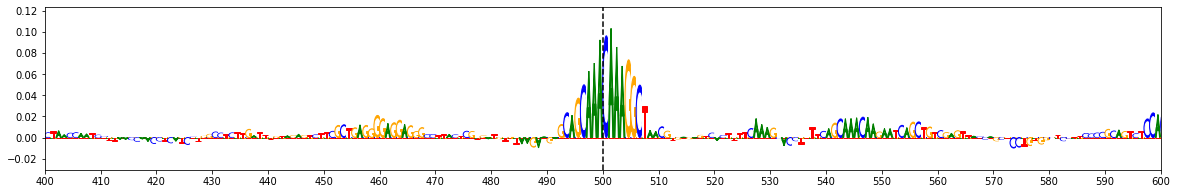

Effect Allele: C   ||   Effect Center: 0.3654   ||   Center / 200bp : 0.289

Effect Motif: CAGCAAACAAAGGCT


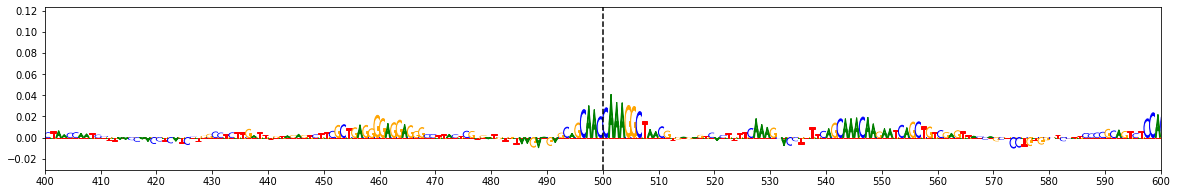

gkmExplain Score: -0.2158  ||  ISM Score: -0.8927  ||  deltaSVM Score: -5.0981

gkmExplain P-Value: 0.033658  ||  ISM P-Value: 0.010085  ||  deltaSVM P-Value: 0.011252

Difference Motif: CAGCAA(A/C)CAAAGGCT


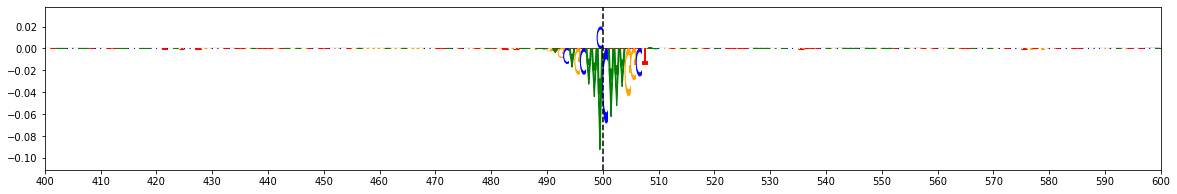



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 206

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.6599   ||   Center / 200bp : 0.3021

Noneffect Motif: GAGGGCGCTGTT


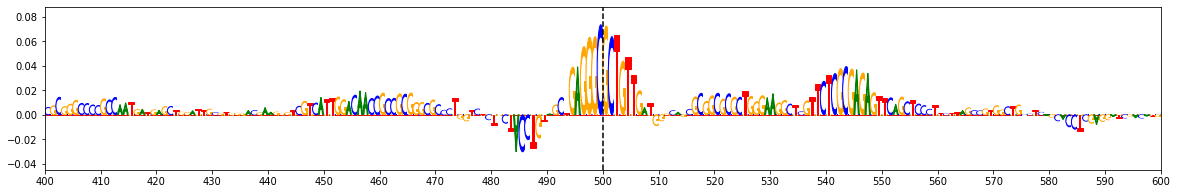

Effect Allele: T   ||   Effect Center: 0.1752   ||   Center / 200bp : 0.1061

Effect Motif: GAGGGCGCTGTT


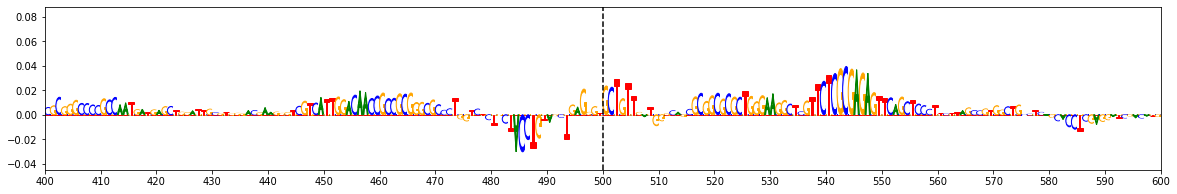

gkmExplain Score: -0.196  ||  ISM Score: -0.8898  ||  deltaSVM Score: -5.1499

gkmExplain P-Value: 0.042062  ||  ISM P-Value: 0.010233  ||  deltaSVM P-Value: 0.010751

Difference Motif: GAGGG(C/T)GCTGTT


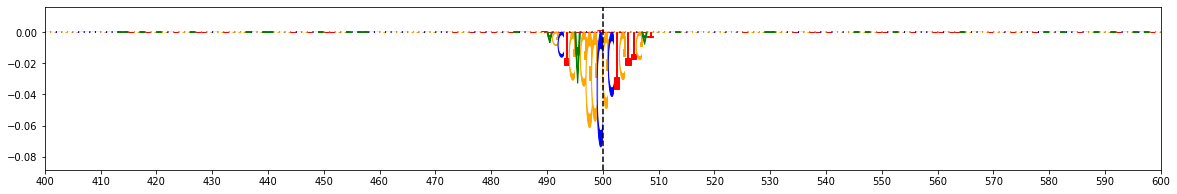



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 53

RSID: rs4889619   ||    chr16 : 31117293 - 31117294   ||    Locus: 48   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 3.4014E-02   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.2622   ||   Center / 200bp : 0.3239

Noneffect Motif: CGGAGGCGG


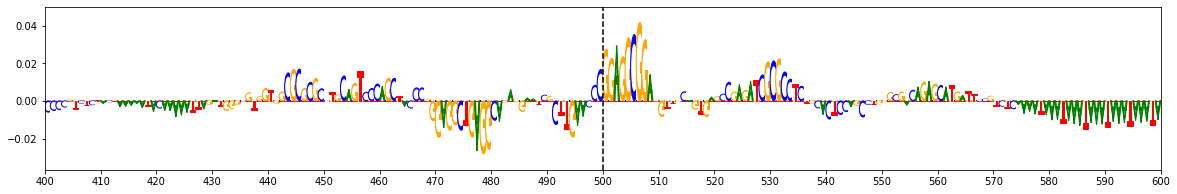

Effect Allele: T   ||   Effect Center: -0.0194   ||   Center / 200bp : 0.1324

Effect Motif: CGGAGGCGG


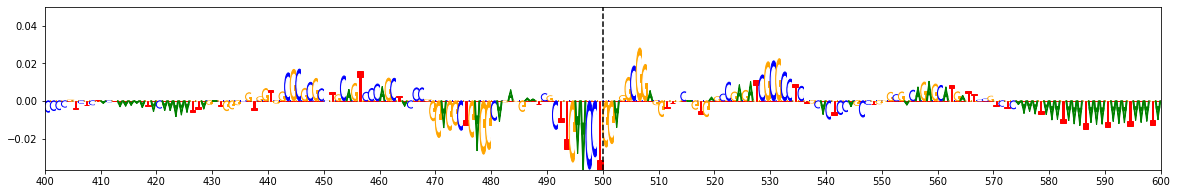

gkmExplain Score: -0.1915  ||  ISM Score: -0.7393  ||  deltaSVM Score: -4.2372

gkmExplain P-Value: 0.044335  ||  ISM P-Value: 0.022485  ||  deltaSVM P-Value: 0.024622

Difference Motif: (C/T)GGAGGCGG


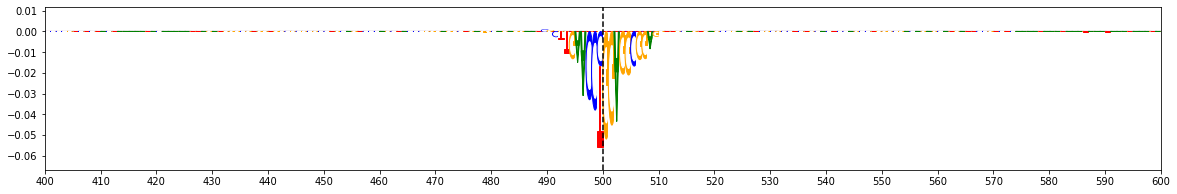



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 262

RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 103   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.4277E-08   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.9579   ||   Center / 200bp : 0.5117

Noneffect Motif: CCAATCAGCGCCTGCCAGACGCT


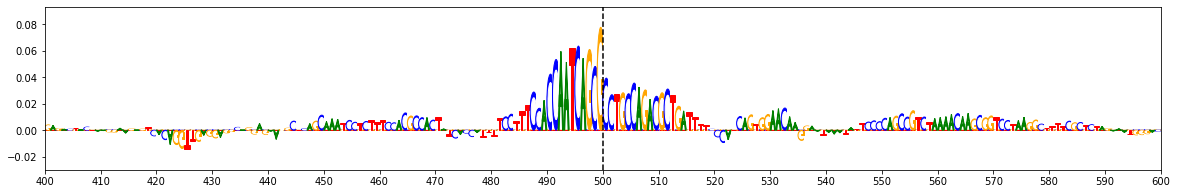

Effect Allele: T   ||   Effect Center: 0.5085   ||   Center / 200bp : 0.3614

Effect Motif: CCAATCAGCGCCTGCCAGACGCT


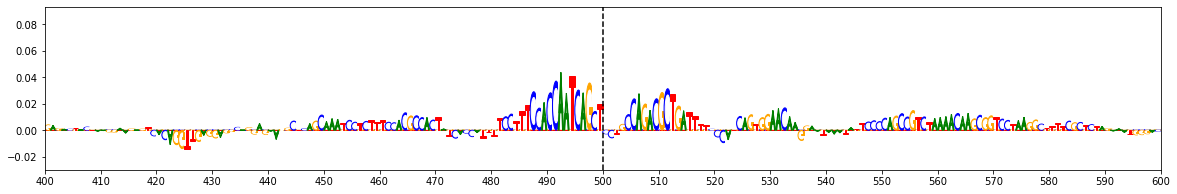

gkmExplain Score: -0.1503  ||  ISM Score: -0.678  ||  deltaSVM Score: -4.1503

gkmExplain P-Value: 0.075568  ||  ISM P-Value: 0.031455  ||  deltaSVM P-Value: 0.026718

Difference Motif: CCAATCAGC(G/T)CCTGCCAGACGCT


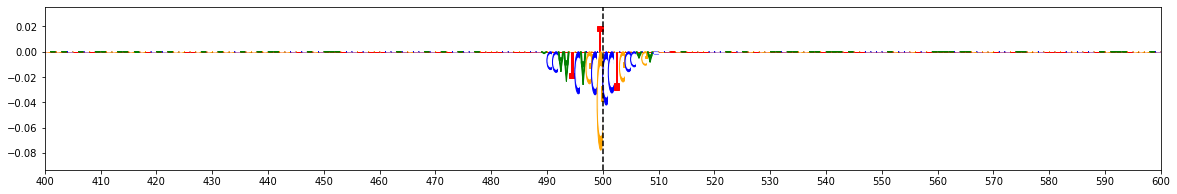



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 24

RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 16   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 7.1431E-16   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.2602   ||   Center / 200bp : 0.133

Noneffect Motif: TGAGTCA


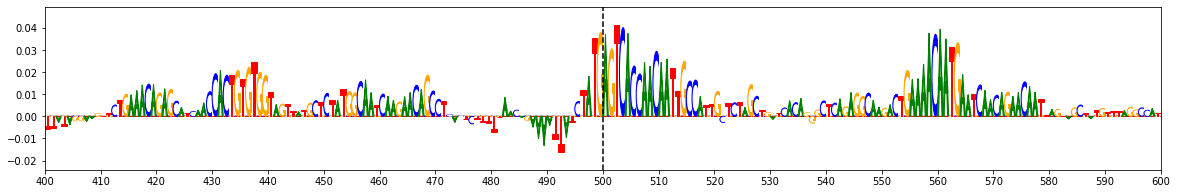

Effect Allele: A   ||   Effect Center: -0.0404   ||   Center / 200bp : 0.0026

Effect Motif: TGAGTCA


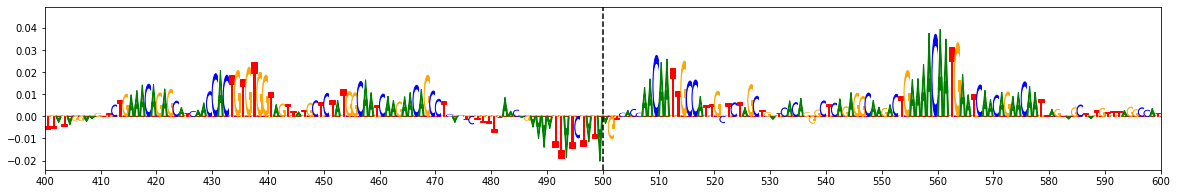

gkmExplain Score: -0.1304  ||  ISM Score: -0.7144  ||  deltaSVM Score: -4.0929

gkmExplain P-Value: 0.101186  ||  ISM P-Value: 0.025743  ||  deltaSVM P-Value: 0.028207

Difference Motif: T(G/A)AGTCA


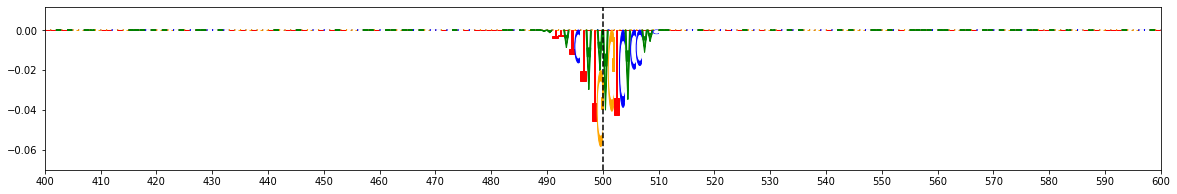



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 266

RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 104   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 1.0848E-03   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0374   ||   Center / 200bp : 0.0332

Noneffect Motif: GAGGCGGCTG


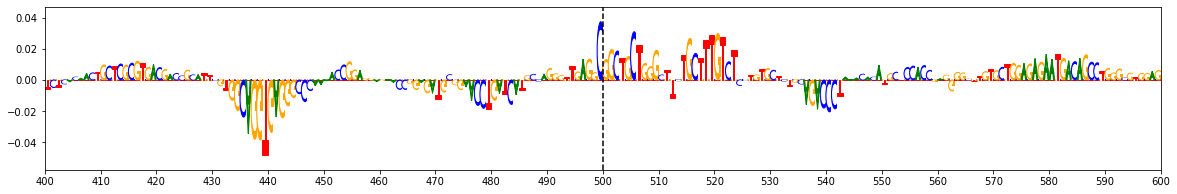

Effect Allele: T   ||   Effect Center: -0.0193   ||   Center / 200bp : 0.0

Effect Motif: GAGGCGGCTG


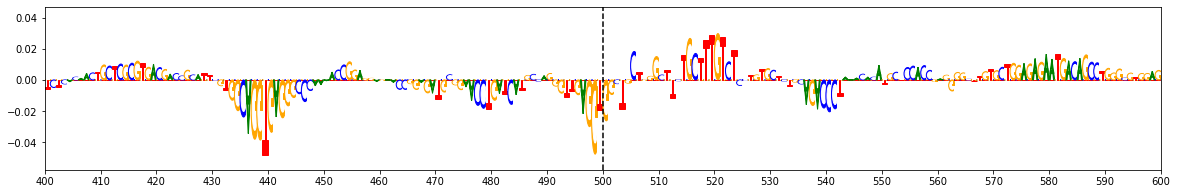

gkmExplain Score: -0.0332  ||  ISM Score: -0.6955  ||  deltaSVM Score: -4.0047

gkmExplain P-Value: 0.577817  ||  ISM P-Value: 0.028549  ||  deltaSVM P-Value: 0.030666

Difference Motif: GAGG(C/T)GGCTG


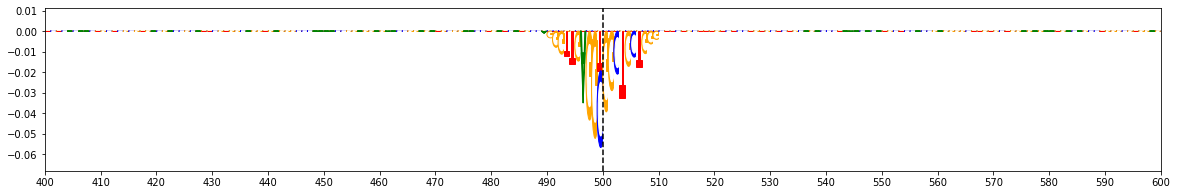



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 128

RSID: rs7218004   ||    chr17 : 75032747 - 75032748   ||    Locus: 61   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 8.5410E-06   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGCGGGTTG


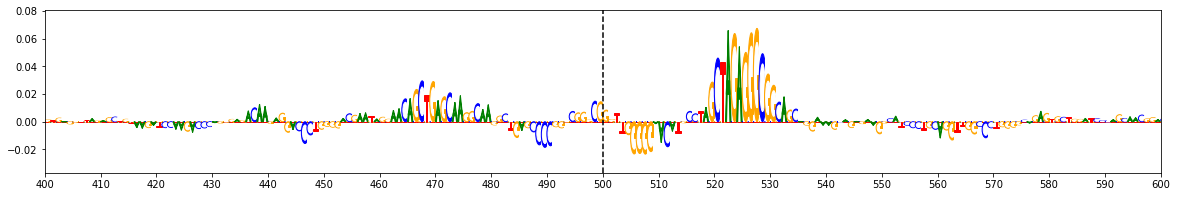

Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGCGGGTTG


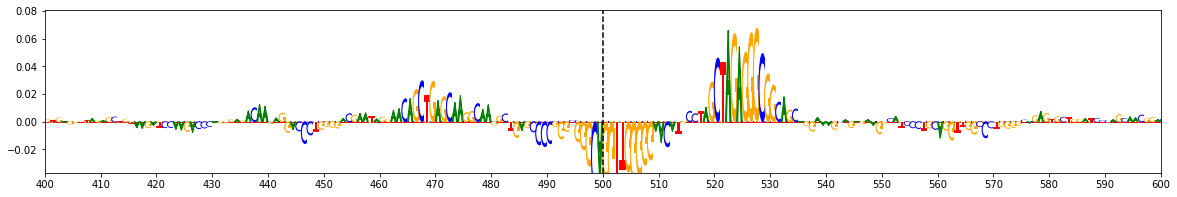

gkmExplain Score: 0.0  ||  ISM Score: -0.7781  ||  deltaSVM Score: -4.4517

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.018256  ||  deltaSVM P-Value: 0.020165

Difference Motif: GGGC(G/A)GGTTG


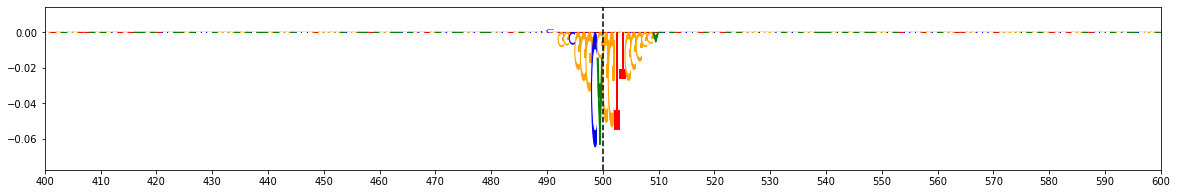



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 217

RSID: rs55911744   ||    chr3 : 122416407 - 122416408   ||    Locus: 86   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.9864E-04   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CACCGGACGC


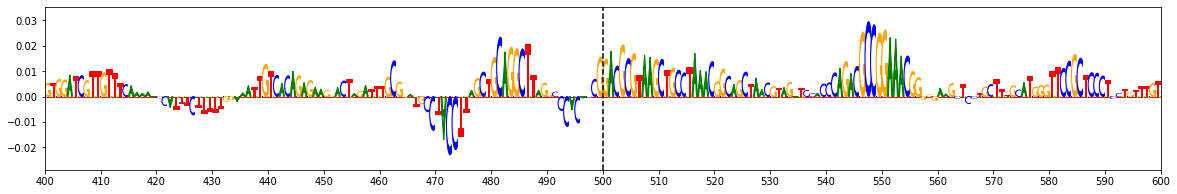

Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CACCGGACGC


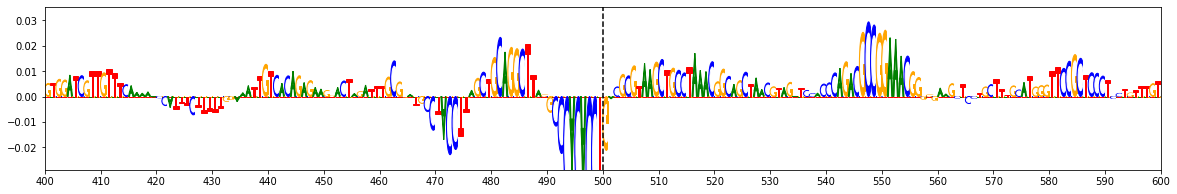

gkmExplain Score: 0.0  ||  ISM Score: -0.6619  ||  deltaSVM Score: -3.8464

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.034392  ||  deltaSVM P-Value: 0.035669

Difference Motif: CACC(G/T)GACGC


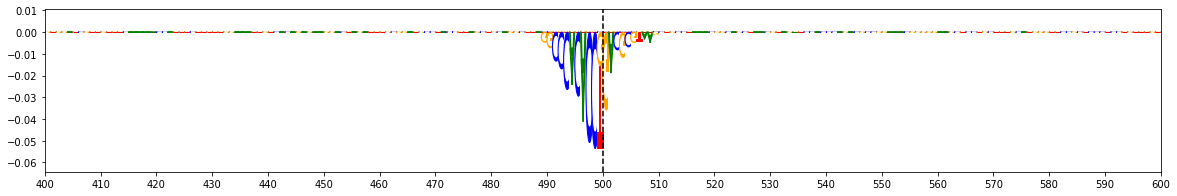



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 79

RSID: rs62057150   ||    chr17 : 45826181 - 45826182   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.3286E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 0.3322   ||   Center / 200bp : 0.2707

Effect Motif: CCATTGGTCG


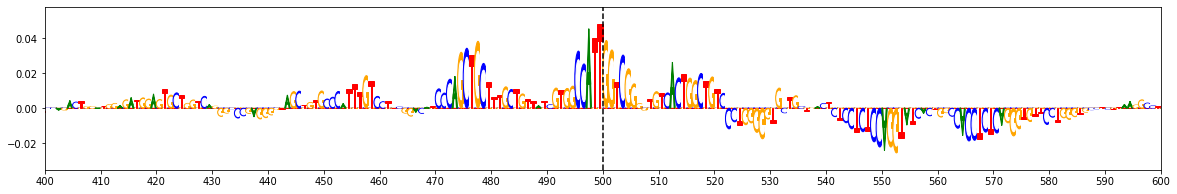

Noneffect Allele: C   ||   Noneffect Center: 0.0342   ||   Center / 200bp : 0.0495

Noneffect Motif: CCATTGGTCG


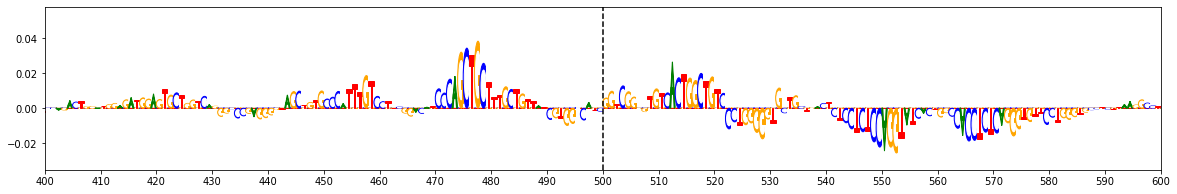

gkmExplain Score: 0.2212  ||  ISM Score: 0.6236  ||  deltaSVM Score: 3.599

gkmExplain P-Value: 0.031732  ||  ISM P-Value: 0.042619  ||  deltaSVM P-Value: 0.045282

Difference Motif: CCAT(T/C)GGTCG


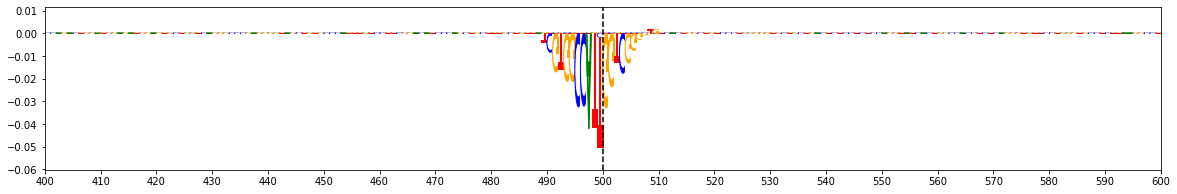



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 123

RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 9.4929E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.5261   ||   Center / 200bp : 0.2858

Effect Motif: CGCCACCTAC


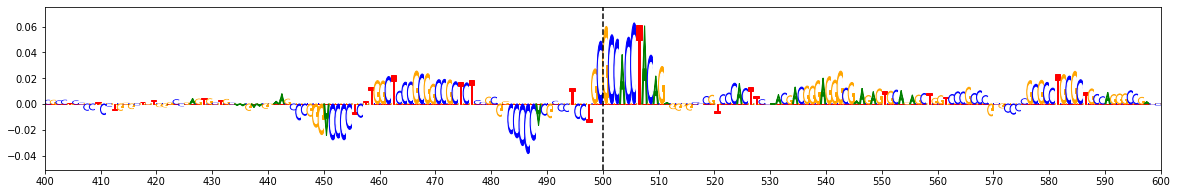

Noneffect Allele: A   ||   Noneffect Center: 0.0902   ||   Center / 200bp : 0.0831

Noneffect Motif: CGCCACCTAC


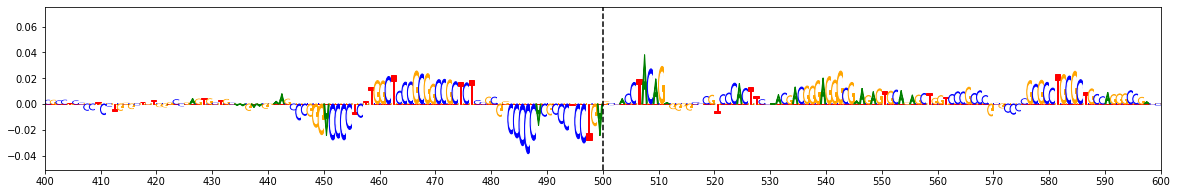

gkmExplain Score: 0.2028  ||  ISM Score: 0.9131  ||  deltaSVM Score: 5.2695

gkmExplain P-Value: 0.038901  ||  ISM P-Value: 0.0091  ||  deltaSVM P-Value: 0.009686

Difference Motif: (C/A)GCCACCTAC


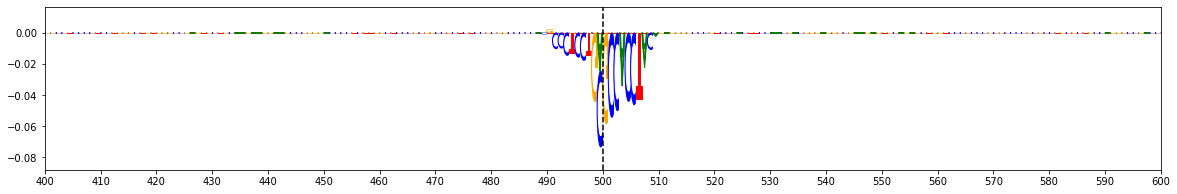



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 133

RSID: rs72914883   ||    chr17 : 78426733 - 78426734   ||    Locus: 62   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.4618E-02   ||    Coloc: False   ||    Confidence: 1


Effect Allele: G   ||   Effect Center: 0.6856   ||   Center / 200bp : 0.2579

Effect Motif: CCGCGCAAGCGC


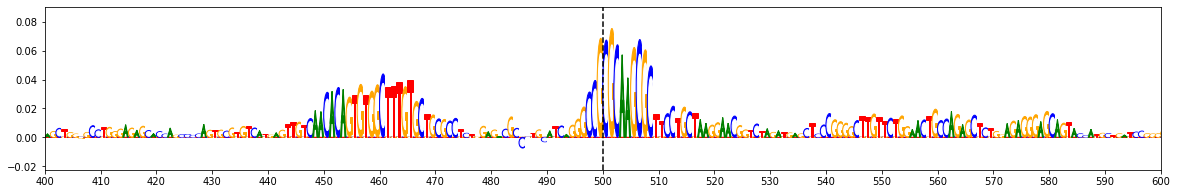

Noneffect Allele: A   ||   Noneffect Center: 0.3153   ||   Center / 200bp : 0.1402

Noneffect Motif: CCGCGCAAGCGC


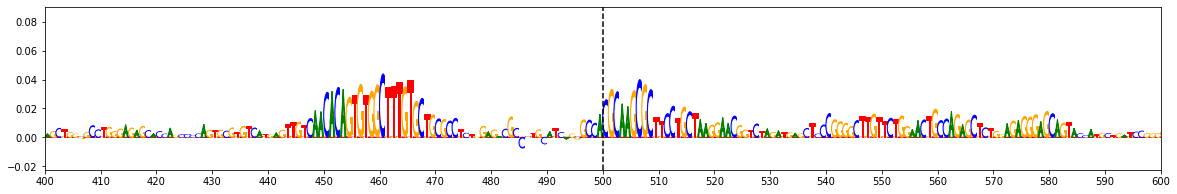

gkmExplain Score: 0.1177  ||  ISM Score: 0.6485  ||  deltaSVM Score: 3.7468

gkmExplain P-Value: 0.123513  ||  ISM P-Value: 0.03706  ||  deltaSVM P-Value: 0.039252

Difference Motif: CC(G/A)CGCAAGCGC


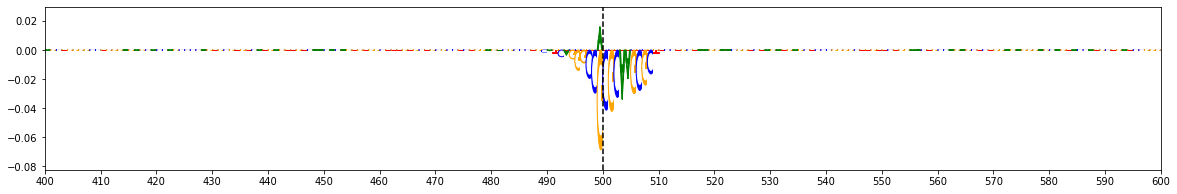



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 211

RSID: rs149776414   ||    chr3 : 52307781 - 52307782   ||    Locus: 93   ||    IDR Peak: False

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 1.0025E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0246   ||   Center / 200bp : 0.02

Effect Motif: GCCCGCCAGG


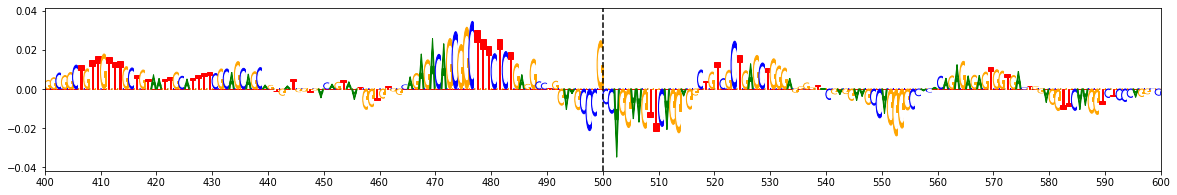

Noneffect Allele: A   ||   Noneffect Center: -0.0339   ||   Center / 200bp : 0.0

Noneffect Motif: GCCCGCCAGG


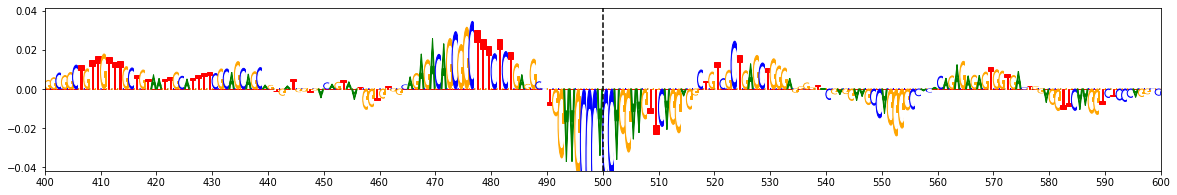

gkmExplain Score: 0.02  ||  ISM Score: 0.747  ||  deltaSVM Score: 4.3322

gkmExplain P-Value: 0.731684  ||  ISM P-Value: 0.021569  ||  deltaSVM P-Value: 0.02253

Difference Motif: GCCC(G/A)CCAGG


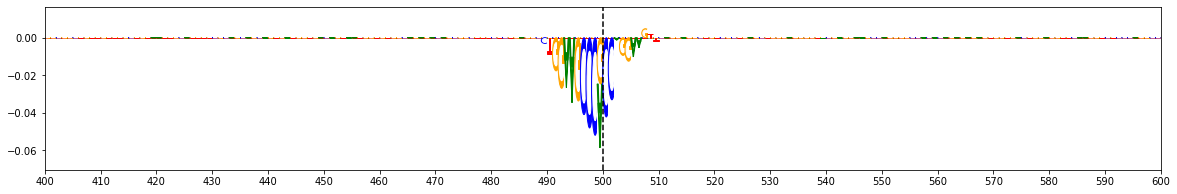



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 154

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


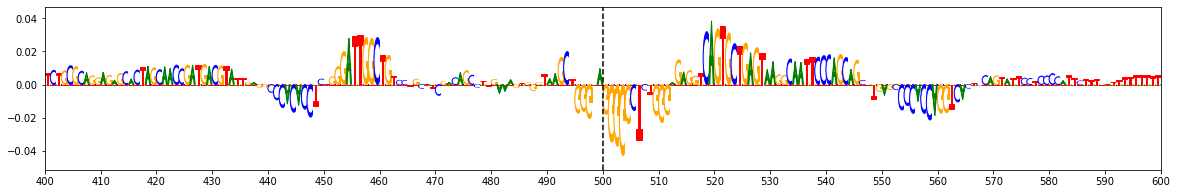

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTAGGGGG


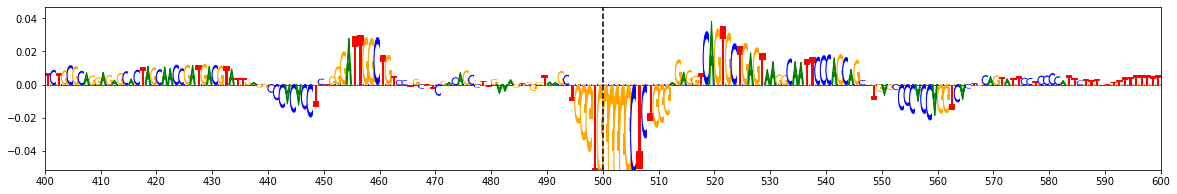

gkmExplain Score: 0.0  ||  ISM Score: 0.8996  ||  deltaSVM Score: 5.1993

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.009739  ||  deltaSVM P-Value: 0.010296

Difference Motif: GGGT(A/G)GGGGG


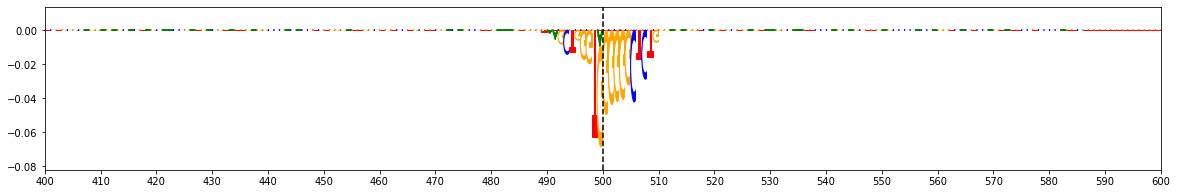



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 280

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCCTGCCGC


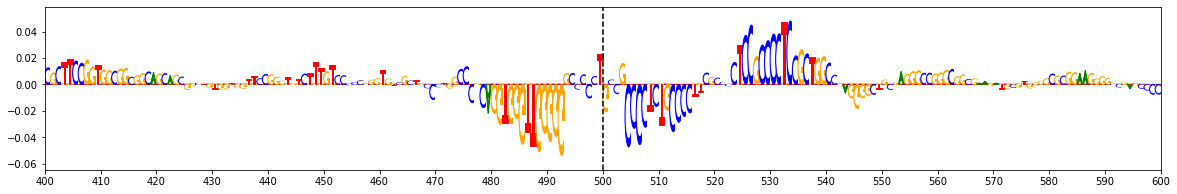

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCTGCCGC


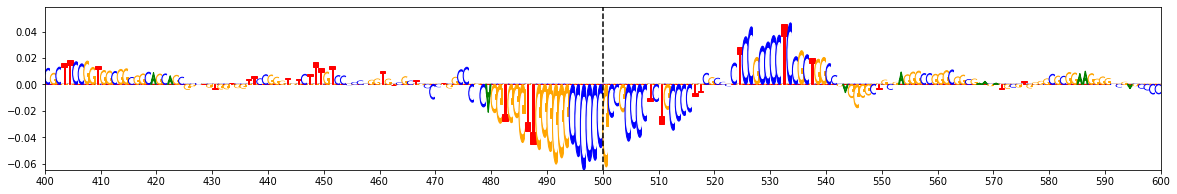

gkmExplain Score: 0.0  ||  ISM Score: 0.812  ||  deltaSVM Score: 5.5098

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.015264  ||  deltaSVM P-Value: 0.007878

Difference Motif: CCCC(T/C)GCCGC


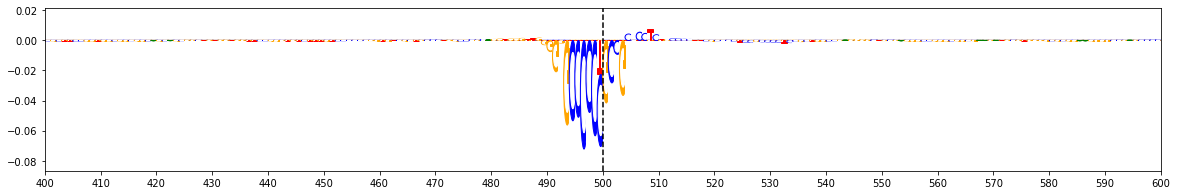



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04089665412902832
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.08613204956054688
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotti

INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygeno

INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.14270520210266113
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. 

INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:

INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04922294616699219
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spac

# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
79,chr17,45826181,45826182,rs62057150,T,C,-,54,23andme_PD_hg38,1.328560e-22,True,True,0.042619,0.045282,0.031732,2,CCATTGGTCG,CCAT(T/C)GGTCG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
270,chr6,27772520,27772521,rs760587,C,A,-,110,Nalls_23andMe,6.436710e-06,False,True,0.010085,0.011252,0.033658,2,CAGCAAACAAAGGCT,CAGCAA(A/C)CAAAGGCT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
123,chr17,46771150,46771151,rs199523,C,A,-,54,23andme_PD_hg38,9.492900e-14,True,False,0.009100,0.009686,0.038901,2,CGCCACCTAC,(C/A)GCCACCTAC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
206,chr3,49007333,49007334,rs6781790,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,True,0.010233,0.010751,0.042062,2,GAGGGCGCTGTT,GAGGG(C/T)GCTGTT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
53,chr16,31117293,31117294,rs4889619,T,C,+,48,Chang_23andMe_Parkinsons,3.401380e-02,False,True,0.022485,0.024622,0.044335,2,CGGAGGCGG,(C/T)GGAGGCGG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
262,chr4,89837895,89837896,rs2619363,T,G,+,103,23andme_PD_hg38,1.427720e-08,True,True,0.031455,0.026718,0.075568,1,CCAATCAGCGCCTGCCAGACGCT,CCAATCAGC(G/T)CCTGCCAGACGCT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
24,chr11,86103987,86103988,rs1237999,A,G,+,16,Alzheimers_Jansen_2018,7.143148e-16,False,True,0.025743,0.028207,0.101186,1,TGAGTCA,T(G/A)AGTCA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
133,chr17,78426733,78426734,rs72914883,G,A,-,62,Nalls_23andMe,4.461790e-02,False,True,0.037060,0.039252,0.123513,1,CCGCGCAAGCGC,CC(G/A)CGCAAGCGC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
266,chr5,103120549,103120550,rs26523,T,C,-,104,Nalls_23andMe,1.084830e-03,False,True,0.028549,0.030666,0.577817,0,GAGGCGGCTG,GAGG(C/T)GGCTG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
211,chr3,52307781,52307782,rs149776414,G,A,-,93,Chang_23andMe_Parkinsons,1.002460e-03,False,False,0.021569,0.022530,0.731684,0,GCCCGCCAGG,GCCC(G/A)CCAGG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
